<a href="https://colab.research.google.com/github/vinotharjun/MachineAsethetics/blob/master/machine_asethetics_MOS_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the data

In [0]:
!wget https://www.dropbox.com/s/sexzq00c3f4eo5z/koniq10k_224x224.zip?dl=1
!unzip /content/koniq10k_224x224.zip?dl=1
!wget http://datasets.vqa.mmsp-kn.de/archives/koniq10k_scores_and_distributions.zip
!unzip koniq10k_scores_and_distributions.zip

--2019-10-01 22:50:46--  https://www.dropbox.com/s/sexzq00c3f4eo5z/koniq10k_224x224.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/sexzq00c3f4eo5z/koniq10k_224x224.zip [following]
--2019-10-01 22:50:46--  https://www.dropbox.com/s/dl/sexzq00c3f4eo5z/koniq10k_224x224.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6245389bd18e2dbbab0f697b9f.dl.dropboxusercontent.com/cd/0/get/AprxxKTVu8KEObBj7zUoJR_2WzQjBlQ3N_pyF0jsCA-wxVLv88SfMIdaB96PI9G5I0tfOc8p1mwdEwtE2bM6o2NRt8qRMpmUe1FLUJ3bRFkCrDn4UhmfqvvKx3YqOyUySoI/file?dl=1# [following]
--2019-10-01 22:50:46--  https://uc6245389bd18e2dbbab0f697b9f.dl.dropboxusercontent.com/cd/0/get/AprxxKTVu8KEObBj7zUoJR_2WzQjBlQ3N_pyF0jsCA-wxVLv88SfMIdaB96PI9G5I0tfOc8p1mwdEwtE2bM6o

In [0]:
!ls 224x224 -1 | wc -l

10373


# Let's Code

## Visualization

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io,transform
import torch
import os
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
columns={'image_name' : 'X' ,'MOS':'y'}
dataset=pd.read_csv("koniq10k_scores_and_distributions.csv")
dataset.rename(columns=columns,inplace=True)
dataset.drop(dataset.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
dataset.tail()

,X,y
10068,9984535544.jpg,3.586538
10069,9991658304.jpg,3.923077
10070,9991999836.jpg,3.920792
10071,9995874256.jpg,3.462963
10072,9996001596.jpg,3.417476


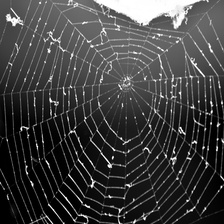

In [0]:
from IPython.display import Image
Image(filename="224x224/9348876103.jpg")

In [0]:
from sklearn.model_selection import train_test_split
dataset_train,dataset_validation =train_test_split(dataset,test_size=0.4)

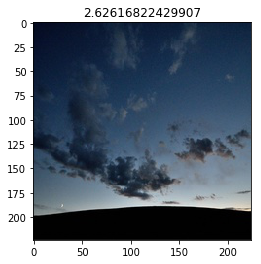

In [0]:

def show_sample_from_dataset(i=0):
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))
  
  image_path=os.path.join("224x224/"+str(dataset_train.iloc[i]["X"]))
  aseth_value = os.path.join(str(dataset_train.iloc[i]["y"]))
  show_image(io.imread(image_path),aseth_value)
show_sample_from_dataset(90)

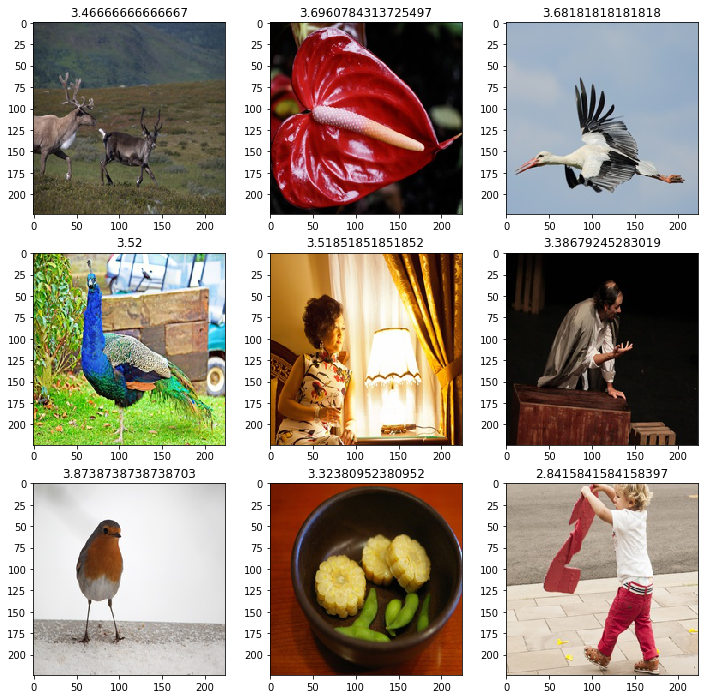

In [0]:
def show_grid(n_row,n_col):
  i=0
  _ ,fig = plt.subplots(n_row, n_col, figsize=(12,12))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("224x224/"+str(dataset_train.iloc[i]["X"]))
    aseth_value = os.path.join(str(dataset_train.iloc[i]["y"]))
    f.imshow(io.imread(image_path))
    f.title.set_text(str(aseth_value))
#     f.title(str(aseth_value))
    i=i+1
show_grid(3,3)

## Statistics

In [0]:
dataset_train["y"].describe()

count    8058.000000
mean        3.165691
std         0.548645
min         1.096154
25%         2.834862
50%         3.283186
75%         3.586538
max         4.310000
Name: y, dtype: float64

In [0]:
dataset_validation["y"].describe()

count    2015.000000
mean        3.147190
std         0.566096
min         1.203704
25%         2.815930
50%         3.272727
75%         3.580655
max         4.245283
Name: y, dtype: float64

## Data preprocessing

## dataset class

In [0]:

class AsetheticsDataset(Dataset):
  '''asethitics dataset'''
  def __init__(self,dataframe,root_dir,transform=None):
    """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = dataframe
#     self.data.rename(columns=columns,inplace=True)
#     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
   
    if torch.is_tensor(idx):
      idx = idx.tolist()
   
    image_name =  os.path.join(self.root_dir,self.data.iloc[idx,0])
    image = io.imread(image_name)
    aseth_val = self.data.iloc[idx,1]
#     return_sample={}
    return_sample = {
          'image':image,
          'asethetics_score':aseth_val 
    }
    if self.transform:
      return_sample = self.transform(return_sample)

     
    return return_sample
    
   

In [0]:

# asethetics_dataset = AsetheticsDataset(dataframe=dataset_train,root_dir="224x224/")

In [0]:
# def show_image(image,asethetics_score):
#   plt.imshow(image)
#   plt.title(str(asethetics_score))
  
# fig = plt.figure(figsize=(10,3))
# for i in range(len(asethetics_dataset)):
#   s = asethetics_dataset[i]
 

  
#   ax = plt.subplot(1,4,i+1)

 
#   show_image(**s)
#   if i == 3:
#         plt.tight_layout()
#         plt.show()
#         break

## transforms

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image,aseth_val = sample['image'], sample['asethetics_score']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w,3))
        
      

        return {'image': img, 'asethetics_score': aseth_val}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image, aseth_val = sample['image'], sample['asethetics_score']
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
      
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'asethetics_score': aseth_val}
      
class Normalize(object):
  def __init__(self,mean,std):
    self.mean=mean
    self.std=std
  def __call__(self,sample):
    image, aseth_val = sample['image'], sample['asethetics_score']
    normalized=  (image -self.mean) / self.std
    return {
        "image":normalized,
        "asethetics_score" : aseth_val
    }

In [0]:

transformed_dataset_train = AsetheticsDataset(dataset_train,root_dir="224x224/",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

transformed_dataset_val= AsetheticsDataset(dataset_validation,root_dir="224x224/",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

In [0]:
# def im_convert(tensor):
#   image = tensor.cpu().clone().detach().numpy()
#   image = image.transpose(1, 2, 0)
#   image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
#   image = image.clip(0, 1)
#   return image
# plt.imshow((sample["image"]))

In [0]:
train_dataloader=DataLoader(transformed_dataset_train,batch_size=128,shuffle=True)
validation_dataloader=DataLoader(transformed_dataset_val,batch_size=128,shuffle=True)

In [0]:
# for i_batch, sample_batched in enumerate(validation_dataloader):
#   print(sample_batched["image"].shape)

# Model creation

In [0]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.6MB/s]


In [0]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in model.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model.fc = last_layer
model.to(device)
print(model.fc.out_features)


1


In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
model = model.double()

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [0]:
epochs = 5
running_loss_history = []
val_running_loss_history=[]

for e in range(epochs):
  running_loss=0.0
  val_running_loss=0.0
  for i,batched_data in enumerate(train_dataloader):
    print(i)
    inputs= batched_data["image"].to(device)
    score = batched_data["asethetics_score"].to(device)
    score=score.view(-1,1)
    score=score.double()
    outputs = model(inputs)
    loss = criterion(outputs,score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    print(loss.item())
  else:
    with torch.no_grad():
      for i,batched_val in enumerate(validation_dataloader):
        val_inputs = batched_val["image"].to(device)
        val_score = batched_val["asethetics_score"].to(device)
        val_score=val_score.view(-1,1)
        val_score=val_score.double()
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_score)
        val_running_loss+=val_loss.item()
#         print(val_loss.item())
    
#   epoch_loss
    epoch_loss = running_loss/len(train_dataloader.dataset)
  
    running_loss_history.append(epoch_loss)
    
    val_epoch_loss = val_running_loss/len(validation_dataloader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    
    print('epoch :', (e+1))
    print('training loss: {:.4f}'.format(epoch_loss))
    print('validation loss: {:.4f}'.format(val_epoch_loss))


0
12.063733465754343
1
11.92845630839841
2
11.493117637114537
3
11.28459538157654
4
11.103613890240421
5
11.123812517819974
6
10.488883380388081
7
10.002600498561765
8
9.503807654289156
9
9.551890084932143
10
9.63310250766158
11
9.315111520672225
12
9.33968328133443
13
8.332280502042146
14
8.417160322132613
15
7.902707516895058
16
7.542845269666062
17
7.472719186402214
18
6.926465120653043
19
7.740870343456085
20
7.299258427389958
21
6.646096186185892
22
6.596717781090832
23
6.519922223070873
24
6.311884107545893
25
6.391118148668269
26
5.775032493868303
27
5.510426791593577
28
5.496227819338094
29
5.062243295320214
30
5.253649198681602
31
4.871106723938125
32
5.039396616616005
33
4.51239208559228
34
4.505616026147184
35
4.3106222150184195
36
4.09162049789085
37
4.140722036924252
38
3.5352855836903463
39
3.790043689862089
40
3.83105698039712
41
3.4781986232944893
42
3.6806842118720136
43
3.220903289640767
44
3.4355163247359815
45
3.3413284182697476
46
3.0819871336832922
47
2.4493134429

NameError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
sap={'epoch': epochs,
            'model_state_dict': model.state_dict(),
              'val_running_loss': val_running_loss_history,
            'running_loss_history':running_loss_history
    }
torch.save(sap, "/content/drive/My Drive/Cv biodata/model.pt")

# Model validation

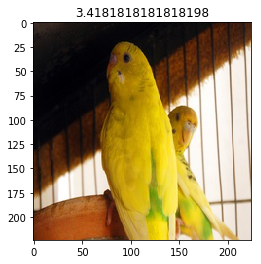

In [0]:
file=""
def show_sample_from_dataset(i=0):
  global file
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))
  
  image_path=os.path.join("224x224/"+str(dataset_validation.iloc[i]["X"]))
  file=image_path
  aseth_value = os.path.join(str(dataset_validation.iloc[i]["y"]))
  show_image(io.imread(image_path),aseth_value)

show_sample_from_dataset(3)

In [0]:
from PIL import Image
image=None
def image_loader(loader, image_name):
    global image
    
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])





print( (model(image_loader(data_transforms,file).double().to(device)).cpu().item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


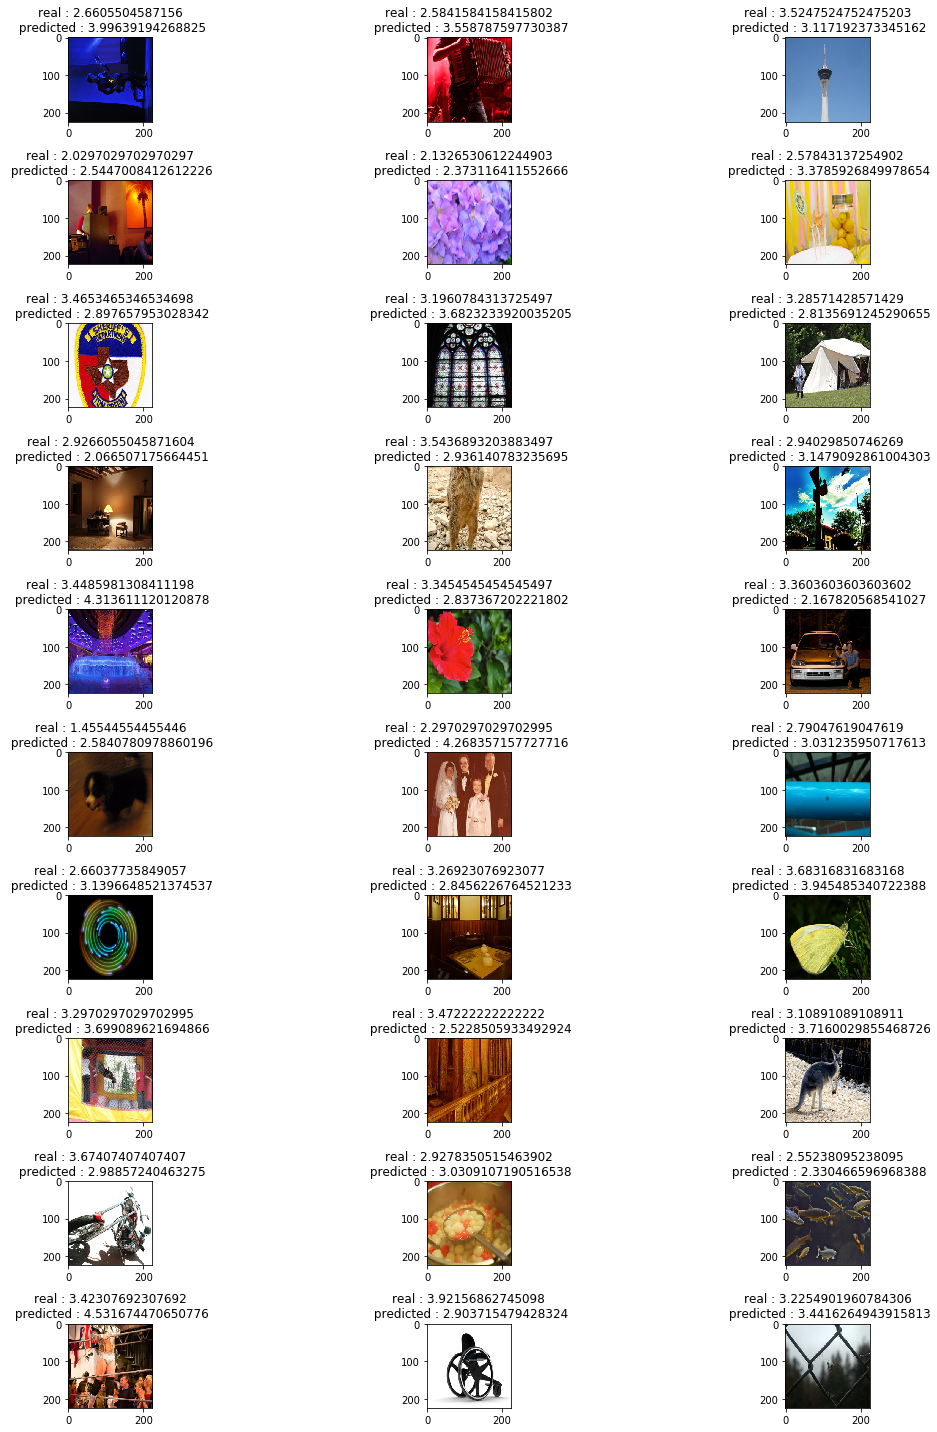

In [0]:
def show_grid(n_row,n_col):
 
  i=80
  _ ,fig = plt.subplots(n_row, n_col, figsize=(20,20))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("224x224/"+str(dataset_validation.iloc[i]["X"]))
    aseth_value = os.path.join(str(dataset_validation.iloc[i]["y"]))
    pred=model(image_loader(data_transforms,image_path).double().to(device)).cpu().item()
    
    f.imshow(io.imread(image_path))
    plt.tight_layout()
    f.title.set_text("real : "+ str(aseth_value)+"\n predicted : "+str(pred))
#     f.title(str(aseth_value))
    i=i+1
show_grid(10,3)

In [0]:
# data_transforms = transforms.Compose([
#     transforms.Resize((224,224)),
 
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# img = data_transforms(img) 
# img.shape

torch.Size([3, 224, 224])

In [0]:
# import PIL.ImageOps
# import requests
# from PIL import Image
 
# url = 'https://www.cheap-chic-weddings.com/images/dont-do-it-bad-wedding-photography-21459892.jpg'
# response = requests.get(url, stream = True)
# img = Image.open(response.raw)
# plt.imshow(img)

In [0]:
# image = img.to(device).unsqueeze(0)
# image=image.double()
# output = model(image)
# print(output[0][0].item())